In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.layers import Dense
from keras.models import Sequential,Model


from tensorflow.keras.optimizers import Adam

In [2]:
class GaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if 1 or training:
            noise = tf.random.normal(tf.shape(inputs), stddev=self.stddev)
            return inputs + noise
        return inputs

    def get_config(self):
        config = super(GaussianNoise, self).get_config()
        config.update({'stddev': self.stddev})
        return config
    
    
class L2Normalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        
        super(L2Normalization, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1)

    def get_config(self):
        return super(L2Normalization, self).get_config()
    

def generate_nakagami_samples(m, omega, shape):

    return tf.random.gamma(shape, m, 1/omega) ** 0.5
    
class NakagamiNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, distribution_params, **kwargs):
        super(NakagamiNoiseLayer, self).__init__(**kwargs)
        self.distribution_params = distribution_params

    def call(self, inputs, training=None):
        if  1 or training:
            # noise = tf.random.normal(tf.shape(inputs), **self.distribution_params)
            if tf.shape(inputs)[0] == None:
                noise = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"], 
                                              shape = tf.shape(inputs))
            else:
                noise = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"], 
                                              shape = tf.shape(inputs)[1:])
            return inputs * noise
        
        else:
            return inputs
        
        





In [3]:
def calc_block_accuracy(preds,y_val):
    n_bits_per_block = preds.shape[1]
    n_correct_bits = np.sum(preds == y_val,axis=1)
    block_accuracy = np.mean(n_correct_bits == n_bits_per_block)
    return block_accuracy



In [4]:
# generating the data set
k = 7
M = 2**k


n_train = 100 * M
n_val = 100 * M

x_train = np.array(np.random.rand(n_train,k)<0.5).astype(np.float32)
y_train = x_train


x_val = np.array(np.random.rand(n_val,k)<0.5).astype(np.float32)
y_val = x_val






In [5]:
MAX_ATTEMPTS_PER_CONFIG = 5
NUM_CHANNEL_USES = 9

# looping pool
OMEGA = 1 # in Nakagami
gamma_bar_collection = [-5,0,5,10,15,20,25,30]
nakagami_m_collection = [1,3,5,7]

In [6]:
complete_results = []


for nakagami_m in nakagami_m_collection:
    for gamma_bar in gamma_bar_collection:
        
        print("\033[91m----------------------start---------------------------\033[0m")
        print(f"\033[91m nakagami_m : {nakagami_m}  gamma_bar : {gamma_bar}\033[0m")
        
        # transform gamma_bar to noise std
        AWGN_std = np.sqrt(OMEGA * 10 ** (-0.1 * gamma_bar) )
        
        accuracies = []
        models = []
        attempts = 0
        while True:
                attempts += 1
                print(f"-------  start of attempt : {attempts} ----------")
                AE = Sequential([


                                        Dense(2*k, activation='tanh',input_shape=(k,)),
                                        Dense(2*k, activation='tanh'),

                                        Dense(2*NUM_CHANNEL_USES, activation='linear'),
                                        L2Normalization(name="normalization_layer"),


                                        NakagamiNoiseLayer({"omega":OMEGA,"m":nakagami_m}),
                                        GaussianNoise(stddev=AWGN_std,name="channel"),

                                        L2Normalization(name="normalization_layer_at_rx"),

                                       # Dense(3*k, activation='tanh'),
                                        Dense(2*k, activation='tanh'),
                                        Dense(k, activation='sigmoid')



                                ])

                AE.build()
                #     AE.summary()

                AE.compile(optimizer=Adam(learning_rate=1e-2),loss="binary_crossentropy")
                AE.fit(x_train,y_train,epochs=10,verbose=0)
                AE.compile(optimizer=Adam(learning_rate=1e-3),loss="binary_crossentropy")
                AE.fit(x_train,y_train,epochs=10,verbose=0)
                
                preds = AE.predict(x_val)>0.5
        #         accuracy = np.mean( preds == y_val  )
                accuracy =  calc_block_accuracy(preds,y_val)
                print(f"accuracy = {accuracy}")

                accuracies.append(accuracy)
                models.append(AE)

                if accuracy > 0.97 or attempts >= MAX_ATTEMPTS_PER_CONFIG:
                    break


        
        
        print(f"Accuracies: {str(accuracies)}")
        print(f"\033[92m\033[1m Best accuracy : {max(accuracies)} \033[0m")
        
        best_block_err_rate = 1 - max(accuracies)
        print(f"\033[94m Best BLERR : {best_block_err_rate} \033[0m")
        
        print("----------------------end-----------------------------\n\n")
        complete_results.append({
            
            "nakagami_m":nakagami_m,
            "gamma_bar": gamma_bar,
            "accuracies":accuracies,
            "models":models,
            "best_block_err_rate":best_block_err_rate
            
            
        })
    

----------------------start---------------------------
 nakagami_m : 1  gamma_bar : -5
-------  start of attempt : 1 ----------
400/400 [==============================] - 1s 992us/step
accuracy = 0.0159375
-------  start of attempt : 2 ----------
400/400 [==============================] - 1s 1ms/step
accuracy = 0.016640625
-------  start of attempt : 3 ----------
400/400 [==============================] - 0s 1ms/step
accuracy = 0.01703125
-------  start of attempt : 4 ----------
400/400 [==============================] - 0s 977us/step
accuracy = 0.0175
-------  start of attempt : 5 ----------
400/400 [==============================] - 1s 1ms/step
accuracy = 0.01828125
Accuracies: [0.0159375, 0.016640625, 0.01703125, 0.0175, 0.01828125]
 Best accuracy : 0.01828125 
 Best BLERR : 0.98171875 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 1  gamma_bar : 0
-------  start of attempt : 1 ----------
400/400 [======

400/400 [==============================] - 1s 1ms/step
accuracy = 0.089921875
-------  start of attempt : 2 ----------
400/400 [==============================] - 1s 1ms/step
accuracy = 0.078046875
-------  start of attempt : 3 ----------
400/400 [==============================] - 1s 1ms/step
accuracy = 0.085546875
-------  start of attempt : 4 ----------
400/400 [==============================] - 1s 1ms/step
accuracy = 0.090234375
-------  start of attempt : 5 ----------
400/400 [==============================] - 1s 1ms/step
accuracy = 0.087890625
Accuracies: [0.089921875, 0.078046875, 0.085546875, 0.090234375, 0.087890625]
 Best accuracy : 0.090234375 
 Best BLERR : 0.909765625 
----------------------end-----------------------------


----------------------start---------------------------
 nakagami_m : 7  gamma_bar : 0
-------  start of attempt : 1 ----------
400/400 [==============================] - 1s 1ms/step
accuracy = 0.270859375
-------  start of attempt : 2 ----------
400/400 

In [7]:
grid = np.zeros((len(nakagami_m_collection),len(gamma_bar_collection)))

for result in complete_results:
    grid[nakagami_m_collection.index(result["nakagami_m"]),
        gamma_bar_collection.index(result["gamma_bar"])] = result["best_block_err_rate"]


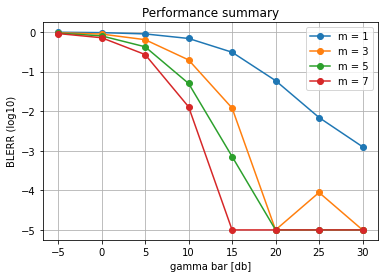

In [13]:
fig,ax  = plt.subplots(1)
for i,nakagami_m in enumerate(nakagami_m_collection):
    ax.plot(gamma_bar_collection,np.log10(grid[i,:] + 1e-5) ,label=f"m = {nakagami_m}",marker="o")
ax.legend()
ax.grid()
ax.set_title("Performance summary")
ax.set_xlabel("gamma bar [db]")
ax.set_ylabel("BLERR (log10)")
plt.show()

In [1]:
grid[1,:]

NameError: name 'grid' is not defined

In [ ]:
# select the best out of all the AE models saved in AE
bestIndex = np.argmax(accuracies)
print("best accuracy: ", max(accuracies))
AE_best = models[bestIndex]

In [ ]:
# bc = before_channel.predict(np.array([
    
#     [0,0],
#     [0,1],
#     [1,0],
#     [1,1]
  
    
# ]))



# bc = before_channel.predict(np.array([

#             [0,0,0,0],
#             [0,0,0,1],
#             [0,0,1,0],
#             [0,0,1,1],
#             [0,1,0,0],
#             [0,1,0,1],
#             [0,1,1,0],
#             [0,1,1,1],
#             [1,0,0,0],
#             [1,0,0,1],
#             [1,0,1,0],
#             [1,0,1,1],
#             [1,1,0,0],
#             [1,1,0,1],
#             [1,1,1,0],
#             [1,1,1,1]
    
# ]))




In [ ]:


before_channel = Model(inputs=AE_best.input,
                                 outputs=AE_best.get_layer('normalization_layer').output)

after_channel  = Model(inputs=AE_best.input,
                                 outputs=AE_best.get_layer('channel').output)

#after_channel_normalized = Model(inputs=AE_best.input,
#                                 outputs=AE_best.get_layer('normalization_layer_at_rx').output)
    
    
bc = before_channel.predict(np.array([
    [0,0,0],
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1],
    
  
  
    
]))
    

ac = after_channel.predict(x_val[:1000,:])
#acn = after_channel_normalized.predict(x_val[:1000,:])


fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].scatter(bc[:,0],bc[:,1],c="red")
ax[0].set_title("before channel")


ax[1].scatter(ac[:,0],ac[:,1],c="blue",s=3)
ax[1].set_title("after channel")


ax[2].scatter(ac[:,0],ac[:,1],c="blue",s=3)
ax[2].scatter(bc[:,0],bc[:,1],c="red") # seconded to avoid occlusion
ax[2].set_title("both before and after channel normalized")


plt.show()

In [ ]:



# # Example usage:
# m = 1.5  # Shape parameter
# omega = 2.0  # Scale parameter
# num_samples = 1000
# nakagami_samples = generate_nakagami_samples((None,num_samples,),m, omega)


# # Compute the histogram
# hist, bins = np.histogram(nakagami_samples, bins=20)  # Adjust the number of bins as needed

# # Plot the histogram
# plt.figure(figsize=(8, 6))
# plt.hist(nakagami_samples, bins=20, color='blue', alpha=0.7)  # Plot the histogram bars
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of Nakagami Samples')
# plt.grid(True)
# plt.show()

In [9]:
bc

NameError: name 'bc' is not defined

In [ ]:
class RicianFadingLayer(tf.keras.layers.Layer):
    def __init__(self, K, stddev, **kwargs):
        super(RicianFadingLayer, self).__init__(**kwargs)
        self.K = K  # Rician factor (K-factor)
        self.stddev = stddev  # Standard deviation of Rayleigh fading

    def call(self, inputs):
        # Generate Rayleigh fading components
#         rayleigh = tf.random.normal(tf.shape(inputs), mean=0.0, stddev=self.stddev)
        rayleigh = tf.random.rayleigh(shape=tf.shape(inputs),scale=self.stddev)
    
        # Generate line-of-sight (LOS) component
        LOS = tf.sqrt(self.K / (self.K + 1)) * tf.random.normal(tf.shape(inputs), mean=0.0, stddev=self.stddev)
        
        # Combine LOS and Rayleigh components
        rician = LOS + rayleigh
        # Apply Rician fading to input signals
        return inputs * rician

# # Example usage:
# # Create a Rician fading layer with K-factor 3 and standard deviation 0.1
# rician_layer = RicianFadingLayer(K=3, stddev=0.1)

# # Generate some input signals
# inputs = tf.random.normal((32, 64))  # Example input shape: (batch_size, input_dim)

# # Apply Rician fading to the input signals
# outputs = rician_layer(inputs)

In [ ]:
preds = AE_best.predict(x_val) > 0.5
accuracy = np.mean(  preds == y_val  )


print(f"accuracy = {accuracy}")
        

In [15]:
grid

array([[0.7825 , 0.7025 , 0.64125, 0.49   , 0.22125, 0.09375, 0.02875,
        0.0375 ],
       [0.71125, 0.6125 , 0.295  , 0.09125, 0.0275 , 0.00125, 0.01375,
        0.     ],
       [0.6525 , 0.5375 , 0.16875, 0.02625, 0.00625, 0.     , 0.     ,
        0.     ],
       [0.64125, 0.3925 , 0.10625, 0.01125, 0.     , 0.     , 0.     ,
        0.     ]])

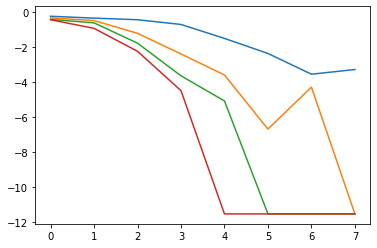

In [18]:
fig,ax  = plt.subplots(1)
for i,nakagami_m in enumerate(nakagami_m_collection):
    ax.plot(np.log(grid[i,:] + 1e-5),label=f"m = {nakagami_m}")
    
plt.show()